# Guia de Prática 6

### -> Passos iniciais:

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Erick Nathan M. Alves & Victor Sidnei Cotta
@data: 15/11/2022
"""

#Importando as bibliotecas:
import numpy as np # importando biblioteca numpy
import matplotlib.pyplot as plt # importando biblioteca para plotar as figuras
import control as ct  #importando biblioteca python control systems

plt.close('all') #comando para fechar todas janelas de plot



#Parâmetros do sistema:
La = .154
L1 = .155
Lt = .270
d = .02
m = .005
rho = 1.23
c = 2.05
mi = 5
g = 9.81

#Constantes do modelo:
K1 = ((d*rho*c*La*L1)/(2*m*(((Lt**2)/12)+(d**2))))
K2 = ((g*d)/(((Lt**2)/12)+(d**2)))
K3 = ((mi*d**2)/(m*(((Lt**2)/12)+(d**2))))

#Dinâmica do sistema:
X0 = [0, 0] #condições iniciais

#Caracterizando o modelo, em espaço de estados:
def model_update(t, x, u, params):
    
    x1 = x[0] # posicao
    x2 = x[1] # velocidade

    #Retorna as derivadas:
    return [x2, ((K1*(np.cos(x1)**2)*u[0]) - ((K2*np.sin(x1)) + (K3*x2)))]

#Função que retorna o estado:
def model_output(t, x, u, params):
    return x

### -> Item 2:

* Levando o sistema ao ponto de operação (27°):

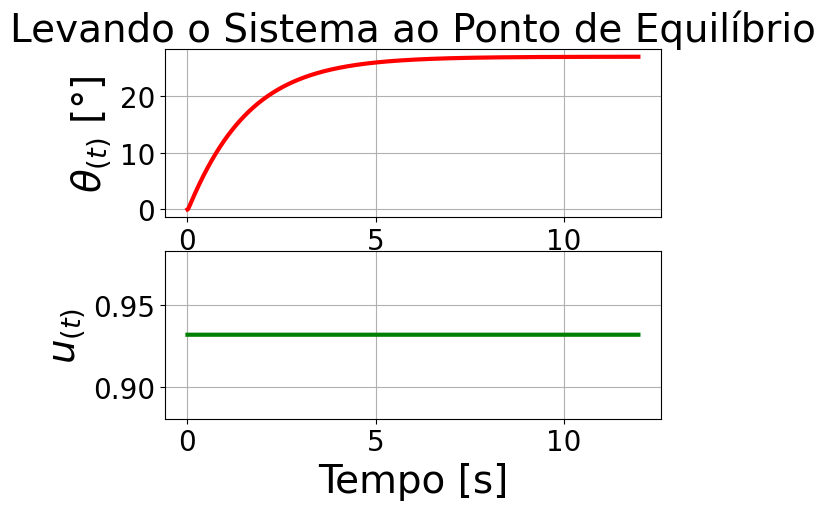

In [5]:
#Parâmetros de simulação:
t = np.arange(0, 12, .01) #criando array de tempo
u_eq = (((K2/K1)*np.sin(np.radians(27)))/(np.cos(np.radians(27))**2)) #sinal que leva ao ponto desejado
u = u_eq*np.ones(t.shape) #criando array com para o sinal

#Instanciando o sistema:
sys = ct.NonlinearIOSystem(model_update, model_output, states=2, name='sys', inputs=('u'), outputs=('x1','x2'))

#Solucionando o sistema em si:
t, x = ct.input_output_response(sys, t, u, X0=X0)
y = x[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(1)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(y),'r', label='$\\theta_{(t)}$', linewidth=3)
plt.ylabel('$\\theta_{(t)}$ [°]', fontsize=28)
plt.title('Levando o Sistema ao Ponto de Equilíbrio', fontsize=28)
plt.grid()
"""""
plt.subplot(3, 1, 2)
plt.plot(t, np.degrees(x[1]), 'b', label='$\omega_{(t)}$', linewidth=3)
plt.ylabel('$\omega_{(t)}$ [°/s]', fontsize=28)
plt.grid()
"""
plt.subplot(2, 1, 2)
plt.plot(t, u, 'g', label='$u_{(t)}$', linewidth=3)
plt.ylabel('$u_{(t)}$', fontsize=28)
plt.xlabel('Tempo [s]', fontsize=28)
plt.grid()
plt.show()

* Aplicação de um degrau de +5° em torno do equilíbrio:

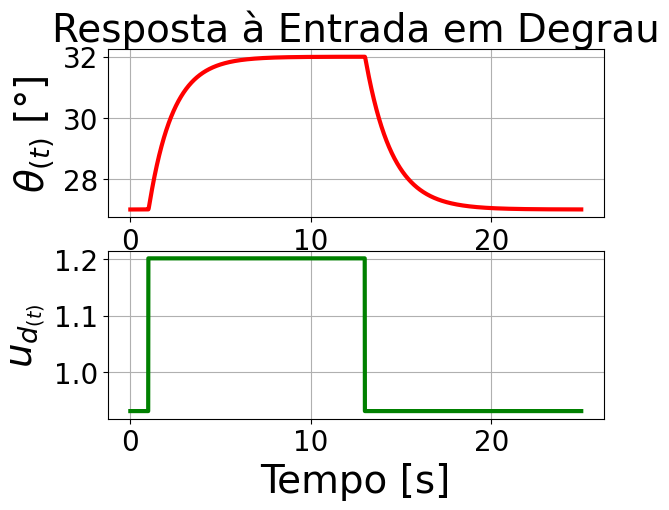

In [6]:
#Parâmetros de simulação:
X0 = [np.radians(27), 0]
ud = (((K2/K1)*np.sin(np.radians(32)))/(np.cos(np.radians(32))**2)) #sinal que aplica o degrau
td = np.arange(0, 25, .01) #criando array de tempo
#Criação do degrau:
u = np.hstack(((u_eq*np.ones(100)), (ud*np.ones(1200)), (u_eq*np.ones(1200))))    

#Solucionando o sistema em si:
td, xd = ct.input_output_response(sys, td, u, X0=X0)
yd = xd[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(2)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.subplot(2, 1, 1)
plt.plot(td, np.degrees(yd),'r', label='$\\theta_{(t)}$', linewidth=3)
plt.ylabel('$\\theta_{(t)}$ [°]', fontsize=28)
plt.title('Resposta à Entrada em Degrau', fontsize=28)
plt.grid()
"""""
plt.subplot(3, 1, 2)
plt.plot(td, np.degrees(xd[1]), 'b', label='$\omega_{(t)}$', linewidth=3)
plt.ylabel('$\omega_{(t)}$ [°/s]', fontsize=28)
plt.grid()
"""
plt.subplot(2, 1, 2)
plt.plot(td, u, 'g', label='$u_{d_{(t)}}$', linewidth=3)
plt.ylabel('$u_{d_{(t)}}$', fontsize=28)
plt.xlabel('Tempo [s]', fontsize=28)
plt.grid()
plt.show()

* Obtenção dos parâmetros para modelo de Ziegler-Nichols, por resposta ao degrau positivo (borda de subida):


 Resposta ao degrau (+5º): 	A = 1	 B = 1.9606	 C = 2.5212


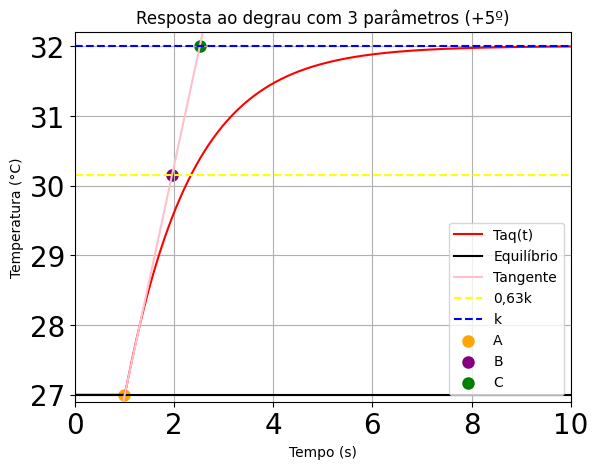

In [8]:
#Equilíbrio:
y0 = (27*np.ones(td.shape))

#Reta tangente:
coef_ang = 3.3
coef_lin = 23.68
y1 = (coef_ang*td + coef_lin) #ajustada graficamente

#Atraso / tempo morto / fase:
A = 1 #obtido graficamente (há uma antecipação que não existe, o atraso é zero aqui, portanto o tempo morto também é zero)!!!!!!!!!!!!!!!

#Reta 0,63K:
y2 = ((27+(0.63*5))*np.ones(td.shape))
B = (((27+(0.63*5))-coef_lin)/coef_ang)

#Reta K:
y3 = (32*np.ones(td.shape))
C = ((32-coef_lin)/coef_ang)

print("\n Resposta ao degrau (+5º): \tA = " + str(round(A, 4)) + "\t B = " + str(round(B, 4)) + "\t C = " + str(round(C, 4)))

plt.figure(3)
plt.plot(td, np.degrees(yd),'red',label='Taq(t)')
plt.plot(td, y0,'black',label='Equilíbrio')
plt.plot(td, y1,'pink',label='Tangente')
plt.plot(td, y2,'yellow',ls='--',label='0,63k')
plt.plot(td, y3,'blue',ls='--',label='k')
plt.scatter(A, 27, c='orange', linewidths=3, label='A')
plt.scatter(B, (27+(0.63*5)), c='purple', linewidths=3, label='B')
plt.scatter(C, 32, c='green', linewidths=3, label='C')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
plt.xlim(0, 10)
plt.legend()
plt.ylim(26.9, 32.2)
plt.title('Resposta ao degrau com 3 parâmetros (+5º)')
plt.grid()
plt.show()

* Validação do modelo:


G: 
  0.3245
-----------
1.521 s + 1



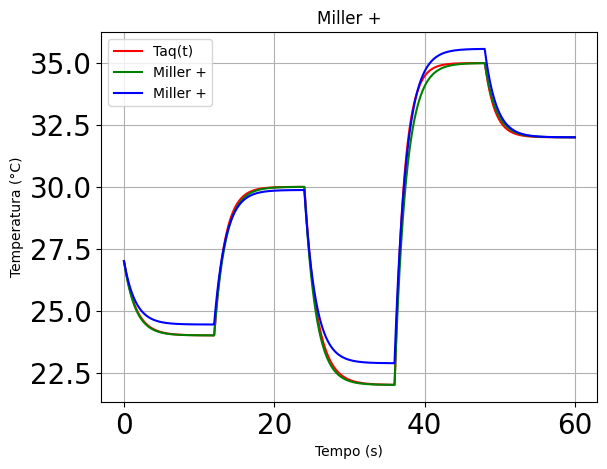

In [9]:
#Resposta ao degrau:
tau = (C-A)
theta = 0
def sd(t, k, tau, theta):
    return (k*(1-np.exp((theta-t)/tau)))

#Criação de degraus:
u1 = (((K2/K1)*np.sin(np.radians(24)))/(np.cos(np.radians(24))**2))*np.ones(1200)
u2 = (((K2/K1)*np.sin(np.radians(30)))/(np.cos(np.radians(30))**2))*np.ones(1200)
u3 = (((K2/K1)*np.sin(np.radians(22)))/(np.cos(np.radians(22))**2))*np.ones(1200)
u4 = (((K2/K1)*np.sin(np.radians(35)))/(np.cos(np.radians(35))**2))*np.ones(1200)
u5 = (((K2/K1)*np.sin(np.radians(32)))/(np.cos(np.radians(32))**2))*np.ones(1200)
uv = np.hstack((u1, u2, u3, u4, u5))

tv = np.arange(0, 60, .01)

ysv = np.hstack(((27+sd(tv[:1200], -3, tau, theta)), (24+sd(tv[:1200], 6, tau, theta)), (30+sd(tv[:1200], -8, tau, theta)), (22+sd(tv[:1200], 13, tau, theta)), (35+sd(tv[:1200], -3, tau, theta))))

#Parâmetros de simulação:
X0 = [np.radians(27), 0]

#Solucionando o sistema em si:
tv, xv = ct.input_output_response(sys, tv, uv, X0=X0)
yv = np.degrees(xv[0])

#Função de transferência para um sistema de primeira ordem superamortecido:
s = ct.tf('s')
K = (np.radians(5)/(ud-u_eq)) #ganho estático do sistema
G = (K/((tau*s)+1))
print('\nG: ' + str(G))

tv, xft = ct.forced_response(G, T=tv, U=(uv-u_eq))
yft = (np.degrees(xft)+27)

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(4)
plt.plot(tv, yv, 'red', label='Taq(t)')
plt.plot(tv, ysv,'green',label='Miller +')
plt.plot(tv, yft,'blue',label='Miller +')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.title('Miller +')
plt.grid()
plt.show()

### Item 3:

* Inclusão do atraso ao modelo obtido:

### Itens 4 e 5:

* Incluindo atraso por aproximação de Padé (ordens: 1, 3, 5 e 9):

### Item 6:

* Simulação da malha fechada:

### Item 7:

* Comparação resposta ao degrau com atraso, para aproximação de Padé de 5ª ordem:

### Itens 8:

* Controlador Proporcional - Ziegler Nichols:

* Controlador Proporcional - CHR:

* Controlador Proporcional Integral - Ziegler Nichols:

* Controlador Proporcional Integral - CHR:

### Item 10:

* Resposta em malha fechada r = [0 1 0 −1 0.5 1 −0.5 0]:

* Rejeição a perturbação:

### Item 12:

* Performance da malha fechada: